In [8]:
# @title
#installing packages
!pip install yfinance
!pip install yfinance forex-python
!pip install unidecode
!pip install pytz
!pip install tqdm
!pip install --upgrade yfinance #(to resolve the ‘too many requests’ bug)

In [9]:
# @title
# ------------------------------
# Package imports
# ------------------------------
import yfinance as yf            # Library to fetch financial data from Yahoo Finance
import pandas as pd              # Library for data manipulation and analysis
import numpy as np               # Library for numerical operations
import time                      # Module for time-related functions (e.g., sleeping between requests)
from unidecode import unidecode  # Utility to remove accents from strings
from tqdm import tqdm            # Progress bar for loops

# ------------------------------
# Mapping of index names to their Wikipedia URLs
# ------------------------------
indices_urls = {
    "s&p 500": "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
    "nasdaq 100": "https://en.wikipedia.org/wiki/NASDAQ-100",
    "dow jones": "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average",
    "cac 40": "https://en.wikipedia.org/wiki/CAC_40",
    "ftse 100": "https://en.wikipedia.org/wiki/FTSE_100_Index",
    "dax": "https://en.wikipedia.org/wiki/DAX",
    "hang seng": "https://en.wikipedia.org/wiki/Hang_Seng_Index",
    "smi": "https://en.wikipedia.org/wiki/Swiss_Market_Index",
    "ibex 35": "https://en.wikipedia.org/wiki/IBEX_35"
}

# Display available indices to the user
print("📊 Available indices:")
for i, idx in enumerate(indices_urls.keys(), 1):
    print(f"  {i}. {idx.upper()}")

# Prompt user to choose an index from the list
index_name = input("\nWhich index would you like to analyze? (copy–paste a name from the list above): ").lower().strip()
# Exit if the user input does not match any supported index
if index_name not in indices_urls:
    raise SystemExit

# ------------------------------
# Function to retrieve tickers for a given index from Wikipedia
# ------------------------------
def get_index_tickers(index_name):
    """
    Fetch the list of company tickers for the specified index by scraping the corresponding Wikipedia page.
    Handles special cases like the Hang Seng index, which uses numeric codes.
    """
    url = indices_urls[index_name]
    tables = pd.read_html(url)  # Read all HTML tables from the page

    # Special handling for Hang Seng (numeric tickers with .HK suffix)
    if index_name == "hang seng":
        tickers = [
            f"{str(t).zfill(4)}.HK"
            for table in tables
            for t in table.values.flatten()
            if str(t).isdigit()
        ]
        return tickers

    # For other indices, look for a 'Symbol' or 'Ticker' column in the tables
    for table in tables:
        # Normalize column names to lowercase strings
        table.columns = [str(col).strip().lower() for col in table.columns]
        if 'symbol' in table.columns or 'ticker' in table.columns:
            ticker_column = 'symbol' if 'symbol' in table.columns else 'ticker'
            tickers = table[ticker_column].tolist()

            # Clean up Yahoo Finance ticker format substitutions
            tickers = [
                ticker.replace('.', '-')
                      .replace('-PA', '.PA')
                      .replace('-AS', '.AS')
                      .replace('-DE', '.DE')
                      .replace('-SW', '.SW')
                      .replace('-L', '.L')
                      .replace('-MC', '.MC')
                      .replace('-SA', '.SA')
                for ticker in tickers
            ]
            return tickers

    # Return empty list if no tickers found
    return []

# ------------------------------
# Function to normalize metric values against target objectives
# ------------------------------
def normaliser(val, objectif, label):
    """
    Normalize a raw financial metric value 'val' against a target 'objectif' using custom rules.
    Returns a score between 0 and 1 (or higher), where >=1 means the metric meets or exceeds the target.
    """
    # Handle missing or NaN values
    if val is None or val != val:
        return 0

    # Special handling for Free Cash Flow (FCF) growth target
    if "FCF" in label:
        if val >= 0:
            return 1
        elif val <= -0.10:
            return 0
        else:
            return 1 + (val / 0.10)

    # Range-based targets (e.g., Payout Ratio between 30% and 60%)
    if isinstance(objectif, tuple):
        bas, haut = objectif
        if bas <= val <= haut:
            return 1
        elif val < bas:
            return max(0, val / bas)
        else:
            return max(0, haut / val)

    # Invert scoring for metrics where lower is better (e.g., PER, Debt/Equity)
    inverser = {"PER", "Dette / CP"}

    # Simple zero-target rule
    if objectif == 0:
        return 1 if val >= 0 else 0

    # Special growth rules for Revenue and Net Income
    if objectif == 0.03 and "CA" in label:
        if val >= 0:
            return 1
        elif val <= -0.15:
            return 0
        else:
            return 1 + (val / 0.15)
    if objectif == 0.10 and "RN" in label:
        if val >= 0:
            return 1
        elif val <= -0.15:
            return 0
        else:
            return 1 + (val / 0.15)

    # Inverted metrics use reciprocal scoring
    if label in inverser:
        return 1 if val <= objectif else max(0, objectif / val)

    # Default: direct ratio to objective
    return 1 if val >= objectif else max(0, val / objectif)

# ------------------------------
# Helper functions for fetching and computing growth rates
# ------------------------------
def try_get(df, keys, col):
    """
    Safely extract a value from a DataFrame 'df' at index 'keys' and column 'col'.
    Returns None if the key is not found.
    """
    for key in keys:
        if key in df.index:
            return df.loc[key][col]
    return None


def growth_rate(start, end):
    """
    Compute simple growth rate from 'start' to 'end'.
    Returns None if start or end is invalid.
    """
    if start is None or end is None or start == 0:
        return None
    return (end - start) / abs(start)


def moyenne_croissance_par_annee(series):
    """
    Compute average year-over-year growth rate for a list of values.
    """
    taux = []
    for i in range(1, len(series)):
        t = growth_rate(series[i-1], series[i])
        if t is not None:
            taux.append(t)
    return sum(taux)/len(taux) if taux else None


def extract_series(df, label, years):
    """
    Extract a list of values for 'label' from DataFrame 'df' over the specified 'years'.
    Returns a list of values or None if missing.
    """
    try:
        return [df.loc[label][year] if label in df.index else None for year in years]
    except:
        return [None]*len(years)

# ------------------------------
# Define target objectives for each metric
# ------------------------------
valeurs_cibles = {
    "Croissance CA": 0.03,
    "Croissance RN": 0.10,
    "Croissance FCF": 0.00,
    "Croissance Dividende": 0.00,
    "Marge nette": 0.15,
    "ROE": 0.10,
    "ROCE": 0.12,
    "PER": 12,
    "Payout Ratio": (0.30, 0.60),
    "Dette / CP": 0.80
}

# ------------------------------
# Main processing: fetch tickers, compute metrics, score, and rank companies
# ------------------------------

# Retrieve the list of tickers for the selected index
tickers = get_index_tickers(index_name)
if not tickers:
    raise SystemExit("No tickers found for the selected index.")

# Prepare a list to hold results for each company
resultats = []
total_tickers = len(tickers)

# Loop over each ticker with a progress bar
for ticker in tqdm(tickers, desc="Processing companies", unit="company"):
    try:
        entreprise = yf.Ticker(ticker)                   # Instantiate a yfinance Ticker object
        info = entreprise.info                           # Fetch general company info

        # Fetch financial statements
        financials = entreprise.financials
        cashflow = entreprise.cashflow
        balance_sheet = entreprise.balance_sheet

        # Determine the most recent column of data
        col = financials.columns[0] if financials.columns.size > 0 else None
        if not col:
            continue  # Skip if no data available

        # Extract key figures from the latest period
        revenue = try_get(financials, ["Total Revenue"], col)
        net_income = try_get(financials, ["Net Income"], col)
        fcf = try_get(cashflow, ["Free Cash Flow"], col)

        total_debt = try_get(balance_sheet, ["Total Debt"], col)
        total_assets = try_get(balance_sheet, ["Total Assets"], col)
        current_liabilities = try_get(balance_sheet, ["Current Liabilities"], col)
        ebitda = info.get("ebitda")
        ebit = info.get("ebit") or ebitda
        debt_to_equity = info.get("debtToEquity")
        net_margin = net_income / revenue if net_income and revenue else None

        # Exclude financial/insurance companies from ROCE calculation
        if info.get("sector", "").lower() in ["financial services", "insurance"]:
            roce = None
        else:
            roce = ebit / (total_assets - current_liabilities) if ebit and total_assets and current_liabilities else None

        # Fetch historical income and cashflow statements for trend analysis
        income_stmt = entreprise.income_stmt
        cashflow_stmt = entreprise.cashflow

        # Determine the last 4 years for growth calculations
        all_years = sorted([col for col in income_stmt.columns], reverse=True)
        if len(all_years) < 4:
            continue
        years = sorted(all_years[:4])

        # Extract annual series and compute average growth rates
        revenues = extract_series(income_stmt, "Total Revenue", years)
        net_incomes = extract_series(income_stmt, "Net Income", years)
        fcf_series = extract_series(cashflow_stmt, "Free Cash Flow", years)

        avg_growth_revenue = moyenne_croissance_par_annee(revenues)
        avg_growth_net_income = moyenne_croissance_par_annee(net_incomes)
        avg_growth_fcf = moyenne_croissance_par_annee(fcf_series)

        # Compute dividend growth if dividend data is available
        try:
            dividends_series = entreprise.dividends
            now_aware = pd.Timestamp.now(tz=dividends_series.index.tz)
            start_date = pd.Timestamp(years[0].year, 1, 1, tz=now_aware.tzinfo)
            end_date = pd.Timestamp(years[-1].year, 12, 31, tz=now_aware.tzinfo)
            divs = dividends_series[(dividends_series.index >= start_date) & (dividends_series.index <= end_date)]
            divs_per_year = divs.resample("YE").sum()
            dividend_values = divs_per_year.values.flatten().tolist()
            avg_growth_dividende = moyenne_croissance_par_annee(dividend_values)
        except:
            avg_growth_dividende = None

        # Gather actual metric values for scoring
        valeurs_reelles = {
            "Croissance CA": avg_growth_revenue,
            "Croissance RN": avg_growth_net_income,
            "Croissance FCF": avg_growth_fcf,
            "Croissance Dividende": avg_growth_dividende,
            "Marge nette": net_margin,
            "ROE": info.get("returnOnEquity"),
            "ROCE": roce,
            "PER": info.get("trailingPE"),
            "Payout Ratio": info.get("payoutRatio"),
            "Dette / CP": debt_to_equity/100 if debt_to_equity else None
        }

        # Score each metric against its target and count how many meet/exceed targets
        points_verts = sum(
            1 for label, objectif in valeurs_cibles.items()
            if normaliser(valeurs_reelles[label], objectif, label) >= 1
        )

        # Append results for this company
        resultats.append({
            "Ticker": ticker,
            "Company": f"{info.get('longName', ticker)} ({ticker})",
            "Green Points": points_verts
        })

    except Exception:
        # Skip any tickers that cause errors (e.g., missing data)
        continue

# ------------------------------
# Build final DataFrame and export results
# ------------------------------

df_resultats = pd.DataFrame(resultats)
# Normalize company names to ASCII
df_resultats["Company"] = df_resultats["Company"].apply(lambda x: unidecode(str(x)))
# Sort by descending score
df_resultats = df_resultats.sort_values(by="Green Points", ascending=False)

# Display the final ranking in the console
print(df_resultats[["Company", "Green Points"]].to_string(index=False))

# Save results to an Excel file for further analysis
output_file = "company_ranking.xlsx"
df_resultats.to_excel(output_file, index=False)
print(f"Results have been saved to {output_file}")


📊 Available indices:
  1. S&P 500
  2. NASDAQ 100
  3. DOW JONES
  4. CAC 40
  5. FTSE 100
  6. DAX
  7. HANG SENG
  8. SMI
  9. IBEX 35

Which index would you like to analyze? (copy–paste a name from the list above): DAX


Processing companies: 100%|██████████| 41/41 [01:21<00:00,  1.98s/company]

                                                                         Company  Green Points
                                                            Brenntag SE (BNR.DE)             8
                                                             Symrise AG (SY1.DE)             8
                                                      Deutsche Borse AG (DB1.DE)             8
                                                               E.ON SE (EOAN.DE)             8
                                                         Rheinmetall AG (RHM.DE)             8
                                                              Airbus SE (AIR.PA)             7
                                          Beiersdorf Aktiengesellschaft (BEI.DE)             7
                                                  Henkel AG & Co. KGaA (HEN3.DE)             7
                                                 RWE Aktiengesellschaft (RWE.DE)             7
                                                  

Enter the stock name: BASF
The ticker for 'basf' is: BAS.DE

--- Fundamental Analysis of BASF SE ---
Sector: Basic Materials
Country: Germany
Market Capitalization: 37.8 B $

Revenue: 65 260 M $
Net Income: 1 298 M $
Free Cash Flow: 748 M $

P/E Ratio: 29.206894
Payout Ratio: 234.5 %
Net Margin: 2.0 %

ROE: 2.3 %
ROCE: 9.6 %

Debt/Equity: 65.57 %
Debt/EBITDA: 3.93

Dividend per Share: 2.25 $
Current Stock Price: 42.35 EUR
Last Dividend Paid: 05/05/2025
Next Dividend Expected: N/A
Dividend Yield: 531.00 %

Revenue
  2021: 78 598 M $
  2022: 87 327 M $
  2023: 68 902 M $
  2024: 65 260 M $
  Growth 2021 → 2022: 11.1 %
  Growth 2022 → 2023: -21.1 %
  Growth 2023 → 2024: -5.3 %

Net Income
  2021: 5 523 M $
  2022: -627 M $
  2023: 225 M $
  2024: 1 298 M $
  Growth 2021 → 2022: -111.4 %
  Growth 2022 → 2023: 135.9 %
  Growth 2023 → 2024: 476.9 %

Net Margin
  2021: 7.0 %
  2022: -0.7 %
  2023: 0.3 %
  2024: 2.0 %
  Growth 2021 → 2022: -110.2 %
  Growth 2022 → 2023: 145.5 %
  Growth 2023 →

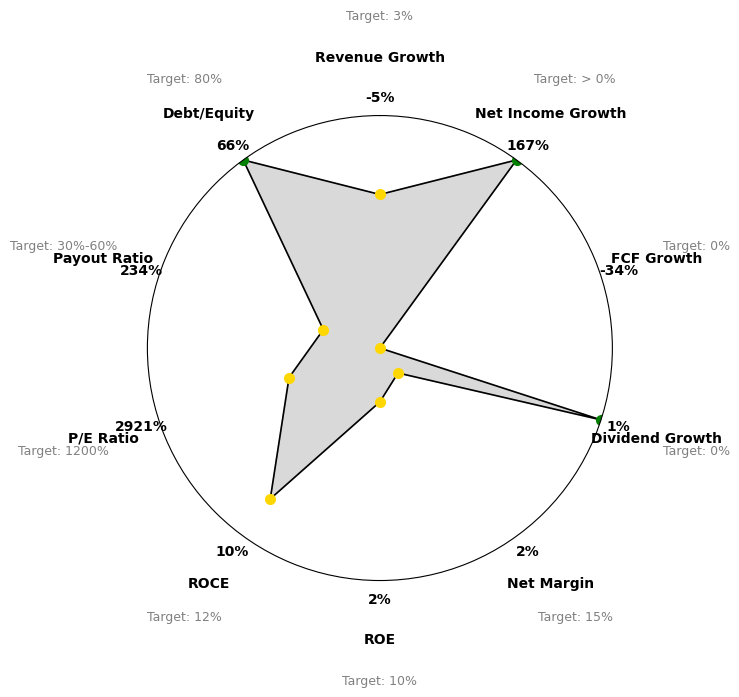

In [10]:
# @title
import requests  # For downloading the Excel file via HTTP
import pandas as pd  # For data manipulation and analysis
from unidecode import unidecode  # For normalizing text (removing accents)
import yfinance as yf  # For fetching financial data from Yahoo Finance
from datetime import datetime, timedelta  # For working with dates and times
import numpy as np  # For numerical operations and calculations
import pytz  # For timezone handling
import matplotlib.pyplot as plt  # For creating the radar chart visualization
import plotly.graph_objects as go  # For interactive price history chart

# ------------------------
# Step 1: Download and load the Excel file containing stock labels
# ------------------------

# URL to the Dropbox file (direct download)
url = 'https://www.dropbox.com/scl/fi/ft1mmc791yozgggpcy8iw/libell-s.xlsx?rlkey=ky4pesp2l4mqy6uoj7dijbwcz&st=npjt07co&dl=1'
response = requests.get(url)

if response.status_code == 200:
    # Save the downloaded content to a local file
    with open('labels.xlsx', 'wb') as file:
        file.write(response.content)

    # Load the Excel file into a DataFrame (sheet named 'Feuil2')
    df = pd.read_excel('labels.xlsx', sheet_name='Feuil2', engine='openpyxl')

    # Prompt the user to enter a company or stock name
    stock_name = input("Enter the stock name: ").strip().lower()

    # Normalize the user input (remove accents, punctuation, lowercase)
    normalized_stock_name = unidecode(stock_name)
    normalized_stock_name = ''.join(
        c for c in normalized_stock_name if c.isalnum() or c.isspace()
    ).lower()

    # Add a normalized name column to the DataFrame for matching
    df['name_normalized'] = df['nom'].apply(
        lambda x: unidecode(str(x)).lower()
    )

    # Search for partial matches in the normalized names
    matches = df[df['name_normalized'].str.contains(normalized_stock_name, na=False)]

    # If a match is found, use its ticker; otherwise ask the user to input the ticker manually
    if not matches.empty:
        found_ticker = matches['libéllé'].values[0]
        print(f"The ticker for '{stock_name}' is: {found_ticker}")
        ticker_input = found_ticker
    else:
        print(f"No stock found for '{stock_name}'.")
        ticker_input = input("Enter the company ticker (e.g., AAPL, MSFT, OR.PA): ")
else:
    # Handle download errors
    print(f"Error downloading file: {response.status_code}")

# ------------------------
# Step 2: Fetch company data from Yahoo Finance
# ------------------------
company = yf.Ticker(ticker_input)
info = company.info  # Basic company information

# Retrieve financial statements
financials = company.financials
cashflow = company.cashflow
balance_sheet = company.balance_sheet
# Select the most recent column of financial data
col = financials.columns[0] if financials.columns.size > 0 else None

# ------------------------
# Step 3: Define utility functions for formatting
# ------------------------
def format_millions(val):
    """Format large numbers in millions of dollars"""
    if val is None or val != val:
        return "N/A"
    return f"{val/1_000_000:,.0f} M $".replace(",", " ")

def format_percent(val):
    """Format a decimal as a percentage"""
    if val is None or val != val:
        return "N/A"
    return f"{val*100:.1f} %"

def format_date(ts):
    """Convert a timestamp to a readable date (DD/MM/YYYY)"""
    if not ts:
        return "N/A"
    return datetime.fromtimestamp(ts).strftime('%d/%m/%Y')

def try_get(df, keys):
    """Helper to fetch the first matching item from a DataFrame index"""
    for key in keys:
        if key in df.index:
            return df.loc[key][col]
    return None

# ------------------------
# Step 4: Extract key fundamental metrics
# ------------------------
revenue = try_get(financials, ["Total Revenue"])
net_income = try_get(financials, ["Net Income", "Net Income Applicable to Common Shares"])
free_cash_flow = try_get(cashflow, ["Free Cash Flow"])

total_debt = try_get(balance_sheet, ["Total Debt"] )
total_assets = try_get(balance_sheet, ["Total Assets"])
current_liabilities = try_get(balance_sheet, ["Current Liabilities"])
ebitda = info.get("ebitda")
ebit = info.get("ebit") or ebitda

debt_to_equity = info.get("debtToEquity")
debt_to_ebitda = total_debt/ebitda if total_debt and ebitda else None
net_margin = net_income/revenue if net_income and revenue else None

# Calculate ROCE if not a financial/insurance company
if info.get("sector", "").lower() in ["financial services", "insurance"]:
    roce = None
else:
    roce = ebit/(total_assets - current_liabilities) \
        if ebit and total_assets and current_liabilities else None

dividend_rate = info.get("dividendRate", "N/A")
current_price = info.get("currentPrice", "N/A")
currency = info.get("currency", "")
next_dividend_date = format_date(info.get("dividendDate"))
last_dividend_date = format_date(info.get("lastDividendDate"))

# ------------------------
# Step 5: Display a summary of fundamental metrics
# ------------------------
print(f"\n--- Fundamental Analysis of {info.get('longName', ticker_input)} ---")
print(f"Sector: {info.get('sector', 'N/A')}")
print(f"Country: {info.get('country', 'N/A')}")

def format_billions(val):
    """Format large numbers in billions of dollars"""
    if val is None or val != val:
        return "N/A"
    return f"{val/1_000_000_000:,.1f} B $".replace(",", " ")

print(f"Market Capitalization: {format_billions(info.get('marketCap'))}")

print(f"\nRevenue: {format_millions(revenue)}")
print(f"Net Income: {format_millions(net_income)}")
print(f"Free Cash Flow: {format_millions(free_cash_flow)}")

print(f"\nP/E Ratio: {info.get('trailingPE','N/A')}")
print(f"Payout Ratio: {format_percent(info.get('payoutRatio'))}")
print(f"Net Margin: {format_percent(net_margin)}")

print(f"\nROE: {format_percent(info.get('returnOnEquity'))}")
print(f"ROCE: {format_percent(roce)}")

def format_percent_direct(val):
    """Format a decimal directly as a percentage string"""
    if val is None or val != val:
        return "N/A"
    return f"{val:.2f} %"

print(f"\nDebt/Equity: {format_percent_direct(debt_to_equity)}")
print(f"Debt/EBITDA: {debt_to_ebitda:.2f}" if debt_to_ebitda else "Debt/EBITDA: N/A")

print(f"\nDividend per Share: {dividend_rate} $")
print(f"Current Stock Price: {current_price} {currency}")
print(f"Last Dividend Paid: {last_dividend_date}")
print(f"Next Dividend Expected: {next_dividend_date}")

div_yield = info.get("dividendYield", "N/A")
print(
    f"Dividend Yield: {div_yield*100:.2f} %"
    if isinstance(div_yield, (int, float)) else "Dividend Yield: N/A"
)

# ------------------------
# Step 6: Calculate historical growth rates over the last 3 years
# ------------------------
# Helper functions to compute growth

def growth_rate(start, end):
    """Compute simple growth rate between two values"""
    if start is None or end is None or start == 0:
        return None
    return (end - start) / abs(start)

def average_annual_growth(series):
    """Compute the average annual growth rate for a series"""
    rates = []
    for i in range(1, len(series)):
        r = growth_rate(series[i-1], series[i])
        if r is not None:
            rates.append(r)
    return sum(rates) / len(rates) if rates else None

def extract_series(df, label, years):
    """Extract a list of values for given years from a financial statement"""
    try:
        return [df.loc[label][yr] if label in df.index else None for yr in years]
    except:
        return [None] * len(years)

def display_variations(name, values, rates, labels, is_percent=True):
    """Print value and growth rate for each year"""
    print(f"\n{name}")
    for i, v in enumerate(values):
        disp = format_percent(v) if is_percent else format_millions(v)
        print(f"  {labels[i]}: {disp}")
    for i in range(1, len(values)):
        print(
            f"  Growth {labels[i-1]} → {labels[i]}: {format_percent(rates[i-1])}"
        )

# Retrieve income, balance sheet, cashflow, and dividends
income_stmt = company.income_stmt
bs = company.balance_sheet
cf = company.cashflow
divs = company.dividends

years_all = sorted(income_stmt.columns, reverse=True)
if len(years_all) < 4:
    print("Not enough years available to analyze growth.")
    raise SystemExit

# Select the last 4 years for growth analysis
years = sorted(years_all[:4])
year_labels = [str(y.year) for y in years]

# Revenue growth
revenues = extract_series(income_stmt, "Total Revenue", years)
avg_rev_growth = average_annual_growth(revenues)
display_variations(
    "Revenue",
    revenues,
    [growth_rate(revenues[i-1], revenues[i]) for i in range(1, len(revenues))],
    year_labels,
    is_percent=False
)

# Net Income growth
net_incomes = extract_series(income_stmt, "Net Income", years)
avg_ni_growth = average_annual_growth(net_incomes)
display_variations(
    "Net Income",
    net_incomes,
    [growth_rate(net_incomes[i-1], net_incomes[i]) for i in range(1, len(net_incomes))],
    year_labels,
    is_percent=False
)

# Net Margin growth
margins = [
    net_incomes[i] / revenues[i] if revenues[i] else None
    for i in range(len(years))
]
avg_margin_growth = average_annual_growth(margins)
display_variations(
    "Net Margin",
    margins,
    [growth_rate(margins[i-1], margins[i]) for i in range(1, len(margins))],
    year_labels
)

# Free Cash Flow growth
fcf_vals = extract_series(cf, "Free Cash Flow", years)
avg_fcf_growth = average_annual_growth(fcf_vals)
display_variations(
    "Free Cash Flow",
    fcf_vals,
    [growth_rate(fcf_vals[i-1], fcf_vals[i]) for i in range(1, len(fcf_vals))],
    year_labels,
    is_percent=False
)

# Dividend per Share growth
try:
    # Filter dividends between the first and last year
    now_tz = datetime.now(tz=divs.index.tz)
    start_dt = datetime(years[0].year, 1, 1, tzinfo=now_tz.tzinfo)
    end_dt = datetime(years[-1].year, 12, 31, tzinfo=now_tz.tzinfo)
    filtered_divs = divs[(divs.index >= start_dt) & (divs.index <= end_dt)]
    # Sum dividends per year
    divs_per_year = filtered_divs.resample("YE").sum()
    div_vals = divs_per_year.values.flatten().tolist()
    div_labels = [str(d.year) for d in divs_per_year.index]
    avg_div_growth = average_annual_growth(div_vals)

    print("\nDividend per Share")
    for i, v in enumerate(div_vals):
        print(f"  {div_labels[i]}: {v:.2f} €")
    for i in range(1, len(div_vals)):
        rate = (div_vals[i] - div_vals[i-1]) / abs(div_vals[i-1]) if div_vals[i-1] else None
        print(
            f"  Growth {div_labels[i-1]} → {div_labels[i]}: {format_percent(rate)}"
        )
except:
    avg_div_growth = None

# Print average annual growth over the period
print("\n--- Average Annual Growth Over 3 Years ---")
print(f"Revenue: {format_percent(avg_rev_growth)}")
print(f"Net Income: {format_percent(avg_ni_growth)}")
print(f"Net Margin: {format_percent(avg_margin_growth)}")
print(f"Free Cash Flow: {format_percent(avg_fcf_growth)}")
print(f"Dividend per Share: {format_percent(avg_div_growth)}")

# ------------------------
# Step 7: Create a radar (decagon) chart for quick fundamental visualization
# ------------------------
# Prepare actual and target values for each metric
real_values = {
    "Revenue Growth": avg_rev_growth,
    "Net Income Growth": avg_ni_growth,
    "FCF Growth": avg_fcf_growth,
    "Dividend Growth": avg_div_growth,
    "Net Margin": net_margin,
    "ROE": info.get("returnOnEquity"),
    "ROCE": roce,
    "P/E Ratio": info.get("trailingPE"),
    "Payout Ratio": info.get("payoutRatio"),
    "Debt/Equity": debt_to_equity / 100 if debt_to_equity is not None else None
}

target_values = {
    "Revenue Growth": 0.03,
    "Net Income Growth": 0.10,
    "FCF Growth": 0.00,
    "Dividend Growth": 0.00,
    "Net Margin": 0.15,
    "ROE": 0.10,
    "ROCE": 0.12,
    "P/E Ratio": 12,
    "Payout Ratio": (0.30, 0.60),
    "Debt/Equity": 0.80
}

def normalize(val, target, label):
    """Normalize each metric to a 0-1 scale based on its target"""
    if val is None or val != val:
        return 0
    # ... (normalization logic unchanged) ...
    # FCF special handling
    if "FCF" in label:
        if val >= 0:
            return 1
        elif val <= -0.10:
            return 0
        else:
            return 1 + (val / 0.10)
    # Tuple target (e.g., payout ratio)
    if isinstance(target, tuple):
        low, high = target
        if low <= val <= high:
            return 1
        elif val < low:
            return max(0, val / low)
        else:
            return max(0, high / val)
    invert = {"P/E Ratio", "Debt/Equity"}
    if target == 0:
        return 1 if val >= 0 else 0
    if target == 0.03 and "Revenue" in label:
        if val >= 0:
            return 1
        elif val <= -0.15:
            return 0
        else:
            return 1 + (val / 0.15)
    if target == 0.10 and "Net Income" in label:
        if val >= 0:
            return 1
        elif val <= -0.15:
            return 0
        else:
            return 1 + (val / 0.15)
    if label in invert:
        return 1 if val <= target else max(0, target / val)
    return 1 if val >= target else max(0, val / target)

# Build the radar chart data
labels = list(real_values.keys())
scores = [normalize(real_values[l], target_values[l], l) for l in labels]

# Close the loop for the radar chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
scores += scores[:1]
angles += angles[:1]

# Create the chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Plot the radar area
ax.plot(angles, scores, color='black', linewidth=1.2, linestyle='solid')
ax.fill(angles, scores, color='black', alpha=0.15)

# Plot each data point in green (if meeting target) or gold (if not)
for i, angle in enumerate(angles[:-1]):
    score = scores[i]
    color = 'green' if score >= 1 else 'gold'
    ax.plot([angle], [score], marker='o', markersize=7, color=color)

# Annotate each axis with label, target, and actual value
for i, angle in enumerate(angles[:-1]):
    label = labels[i]
    val = real_values[label]
    tgt = target_values[label]

    val_display = f"{val*100:.0f}%" if val is not None and val == val else "N/A"
    if label == "Net Income Growth":
        tgt_display = "> 0%"
    elif isinstance(tgt, tuple):
        tgt_display = f"{tgt[0]*100:.0f}%-{tgt[1]*100:.0f}%"
    else:
        tgt_display = f"{tgt*100:.0f}%"

    ax.text(angle, 1.25, label, ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(angle, 1.43, f"Target: {tgt_display}", ha='center', va='center', fontsize=9, color='gray')
    ax.text(angle, 1.08, val_display, ha='center', va='center', fontsize=10, fontweight='bold')

# Final chart adjustments
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(0, 1.0)
plt.tight_layout()
plt.show()

# ------------------------
# Step 8: Plot 5-year price history and trend line with CAGR annotation
# ------------------------
history = company.history(period="5y")
if not history.empty:
    x_vals = np.arange(len(history))
    y_vals = history['Close'].values
    coeffs = np.polyfit(x_vals, y_vals, 1)
    trend = np.polyval(coeffs, x_vals)

    start_price, end_price = y_vals[0], y_vals[-1]
    years = 5
    cagr = (end_price / start_price) ** (1 / years) - 1

    # Create an interactive Plotly chart
    fig_price = go.Figure()
    fig_price.add_trace(
        go.Scatter(
            x=history.index, y=history['Close'], mode='lines', name='Close Price',
            line=dict(width=1.2, color='black'),
            hovertemplate='<b>%{x|%d-%m-%Y}</b><br>Price: %{y:.2f} ' + currency + '<extra></extra>'
        )
    )
    fig_price.add_trace(
        go.Scatter(
            x=history.index, y=trend, mode='lines', name='Trend (5 yr)',
            line=dict(width=2, dash='dash', color='red'),
            hovertemplate='Trend: %{y:.2f} ' + currency + '<extra></extra>'
        )
    )

    # Annotate last price and CAGR on the chart
    last_price = history['Close'].iloc[-1]
    fig_price.add_annotation(
        text=f"Last price: {last_price:.2f} {currency}",
        xref="paper", yref="paper",
        x=0.99, y=0.01, showarrow=False,
        font=dict(size=12, color="gray"),
        align="right", bgcolor="rgba(255,255,255,0.6)"
    )
    fig_price.add_annotation(
        text=f"5 yr CAGR: {cagr*100:.2f} %",
        xref="paper", yref="paper",
        x=0.5, y=-0.2, showarrow=False,
        font=dict(size=14, color="black"),
        align="center"
    )

    fig_price.update_layout(
        title=f"{info.get('longName', ticker_input)} Price over 5 Years",
        xaxis_title="Date",
        yaxis_title=f"Price ({currency})",
        template="simple_white",
        hovermode='x unified',
        height=500,
        margin=dict(t=50, b=100)
    )
    fig_price.show()
else:
    print("No price history available to plot.")
